## fastai Machine Learning 1 -- Random Forests

CodeAlong / Reimplementation of: https://github.com/fastai/fastai/blob/master/courses/ml1/lesson1-rf.ipynb

## Imports

In [44]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [46]:
PATH = "data/bulldozer/"

In [47]:
!ls {PATH}

Machine_Appendix.csv		  Test.csv	     Train.zip
median_benchmark.csv		  TrainAndValid.csv  Valid.csv
random_forest_benchmark_test.csv  Train.csv	     Valid.zip


## Data

In [48]:
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False,
                     parse_dates=["saledate"])

In [49]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000):
        with pd.option_context("display.max_columns", 1000):
            display(df)

In [50]:
display_all(df_raw.tail().transpose())

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-10-25 00:00:00,2011-10-25 00:00:00


In [51]:
display_all(df_raw.describe(include='all').transpose())

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
SalesID,401125,NaN,NaN,NaN,NaN,NaN,1.91971e+06,909021,1.13925e+06,1.41837e+06,1.63942e+06,2.24271e+06,6.33334e+06
SalePrice,401125,NaN,NaN,NaN,NaN,NaN,31099.7,23036.9,4750,14500,24000,40000,142000
MachineID,401125,NaN,NaN,NaN,NaN,NaN,1.2179e+06,440992,0,1.0887e+06,1.27949e+06,1.46807e+06,2.48633e+06
ModelID,401125,NaN,NaN,NaN,NaN,NaN,6889.7,6221.78,28,3259,4604,8724,37198
datasource,401125,NaN,NaN,NaN,NaN,NaN,134.666,8.96224,121,132,132,136,172
auctioneerID,380989,NaN,NaN,NaN,NaN,NaN,6.55604,16.9768,0,1,2,4,99
YearMade,401125,NaN,NaN,NaN,NaN,NaN,1899.16,291.797,1000,1985,1995,2000,2013
MachineHoursCurrentMeter,142765,NaN,NaN,NaN,NaN,NaN,3457.96,27590.3,0,0,0,3025,2.4833e+06
UsageBand,69639,3,Medium,33985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
saledate,401125,3919,2009-02-16 00:00:00,1932,1989-01-17 00:00:00,2011-12-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

### Initial Processing

In [53]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df_raw.drop('SalePrice', axis=1), df_raw.SalePrice)

ValueError: could not convert string to float: 'Conventional'

In [54]:
add_datepart(df_raw, 'saledate')
df_raw.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

In [55]:
train_cats(df_raw)

In [56]:
df_raw.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

In [57]:
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

In [58]:
df_raw.UsageBand = df_raw.UsageBand.cat.codes

In [59]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

In [60]:
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/bulldozers-raw.feather')

### Pre-processing

In [ ]:
# df_raw = pd.read_feather('tmp/bulldozers-raw.feather')

In [61]:
df, y, nas = proc_df(df_raw, 'SalePrice')

In [63]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df, y)

0.98306975039144351

In [64]:
def split_vals(a, n): return a[:n].copy(), a[n:].copy()

n_valid = 12000 # same as Kaggle's test set size
n_trn = len(df) - n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((389125, 66), (389125,), (12000, 66))

# Random Forests

## Base Model

In [65]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid), 
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [66]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1min 21s, sys: 80 ms, total: 1min 21s
Wall time: 14.8 s
[0.09058973444097133, 0.25014216610390605, 0.98284886761363044, 0.88825662440765263]


## Speeding things up

In [67]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=nas)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [68]:
m = RandomForestRegressor(n_jobs=-1) # n_jobs=-1: set to num. cores on CPU
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 2.94 s, sys: 8 ms, total: 2.95 s
Wall time: 660 ms
[0.10478667374880896, 0.3424332786825167, 0.97780286402648875, 0.790588801595281]


## Single tree

In [70]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.4965829795739235, 0.524683225855184, 0.50149617735615859, 0.50836551980878641]


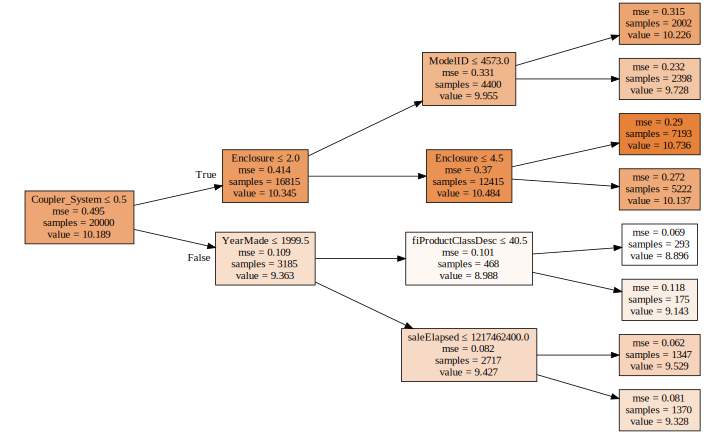

In [71]:
draw_tree(m.estimators_[0], df_trn, precision=3)

Bigger tree:

In [73]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[8.331852114593072e-17, 0.4629095869600437, 1.0, 0.61731598269683918]


## Bagging

### Intro to Bagging